In [11]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import torch

In [12]:


def save_img_from_npy(npy_path, img_path):
    img = np.load(npy_path)
    img = np.expand_dims(img, axis=0)
    img = img * 255
    img = np.transpose(img, (1, 2, 0))
    cv2.imwrite
    cv2.imwrite(img_path, img)



target_path = "pretrain/no_sub"
npy_path = "Dataset/no_sub"

os.makedirs(target_path, exist_ok=True)

# for file in tqdm(os.listdir(npy_path)):
#     if file.endswith(".npy"):
#         save_img_from_npy(npy_path + "/" + file, target_path + "/" + file[:-4] + ".png")


In [13]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os

transform_train = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        
        ])
dataset_train = datasets.ImageFolder(os.path.join("pretrain", ''), transform=transform_train)

In [14]:
dataset_train

Dataset ImageFolder
    Number of datapoints: 29449
    Root location: pretrain/
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
           )

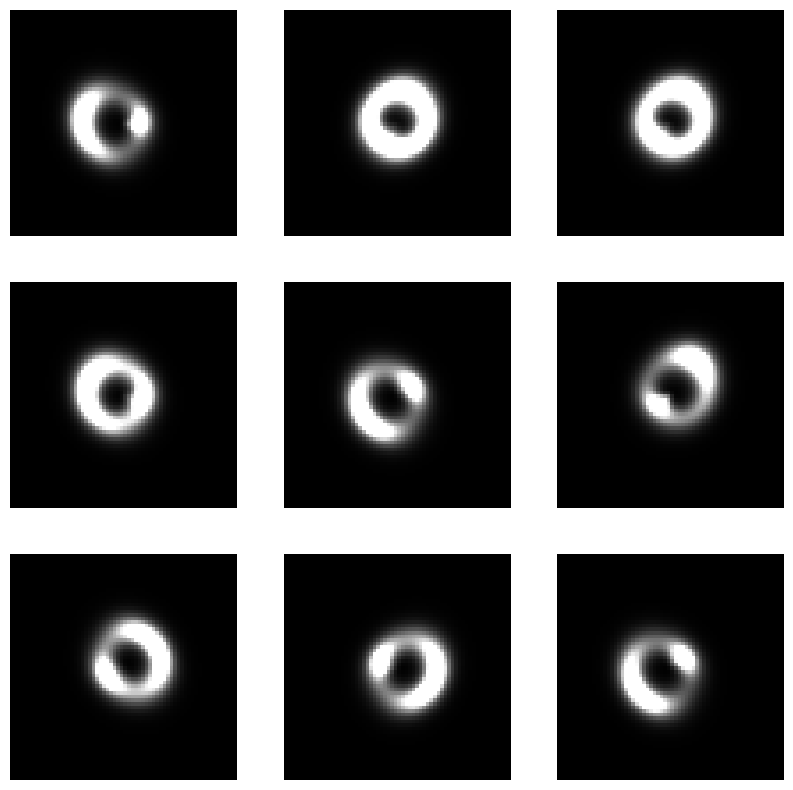

In [15]:
#Plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(dataset_train[i][0].permute(1, 2, 0))
    plt.axis("off")

    

In [16]:
import torch
import timm
import numpy as np

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block

def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes

class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=12,
                 num_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits


if __name__ == '__main__':
    shuffle = PatchShuffle(0.75)
    a = torch.rand(16, 2, 10)
    b, forward_indexes, backward_indexes = shuffle(a)
    print(b.shape)

    img = torch.rand(2, 3, 32, 32)
    encoder = MAE_Encoder()
    decoder = MAE_Decoder()
    features, backward_indexes = encoder(img)
    print(forward_indexes.shape)
    predicted_img, mask = decoder(features, backward_indexes)
    print(predicted_img.shape)
    loss = torch.mean((predicted_img - img) ** 2 * mask / 0.75)
    print(loss)

torch.Size([4, 2, 10])
torch.Size([16, 2])
torch.Size([2, 3, 32, 32])
tensor(0.4144, grad_fn=<MeanBackward0>)


100%|██████████| 1657/1657 [01:41<00:00, 16.38it/s]


Epoch : 0 Loss : 0.0022791444789618254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06361632..1.1751907].


Test Loss : 0.0025529710588523664


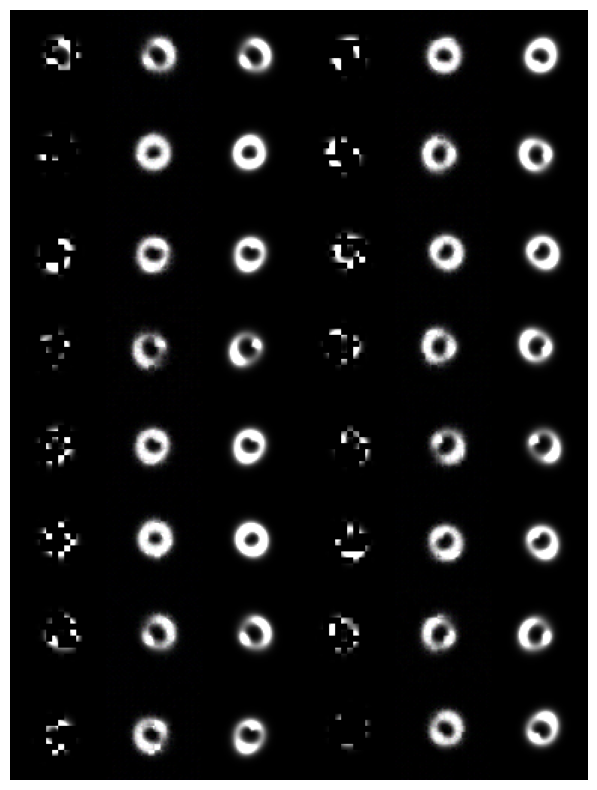

100%|██████████| 1657/1657 [01:40<00:00, 16.54it/s]


Epoch : 1 Loss : 0.0014268591767176986
Test Loss : 0.0015421249869128537


100%|██████████| 1657/1657 [01:40<00:00, 16.52it/s]


Epoch : 2 Loss : 0.0008981904829852283
Test Loss : 0.0013400039512890618


100%|██████████| 1657/1657 [01:34<00:00, 17.54it/s]


Epoch : 3 Loss : 0.0005440269014798105
Test Loss : 0.0007499217642534121


100%|██████████| 1657/1657 [01:38<00:00, 16.78it/s]


Epoch : 4 Loss : 0.00035787292290478945
Test Loss : 0.0006199773336521576


100%|██████████| 1657/1657 [01:38<00:00, 16.87it/s]


Epoch : 5 Loss : 0.00047347828513011336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01600688..1.080645].


Test Loss : 0.00046879335879222364


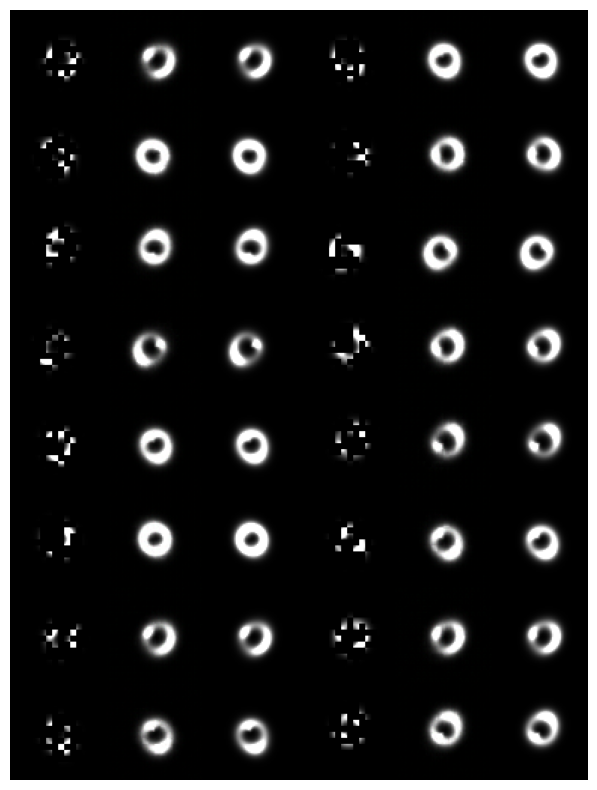

100%|██████████| 1657/1657 [01:38<00:00, 16.85it/s]


Epoch : 6 Loss : 0.0005751861608587205
Test Loss : 0.000382503864789583


100%|██████████| 1657/1657 [01:38<00:00, 16.76it/s]


Epoch : 7 Loss : 0.0003097658627666533
Test Loss : 0.0004851979302632547


100%|██████████| 1657/1657 [01:39<00:00, 16.66it/s]


Epoch : 8 Loss : 0.00029643281595781446
Test Loss : 0.0003455641262573064


100%|██████████| 1657/1657 [01:34<00:00, 17.51it/s]


Epoch : 9 Loss : 0.00024359719827771187
Test Loss : 0.00021729945929601437


100%|██████████| 1657/1657 [01:39<00:00, 16.68it/s]


Epoch : 10 Loss : 0.00018287776038050652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009195849..1.0763168].


Test Loss : 0.000202858069482121


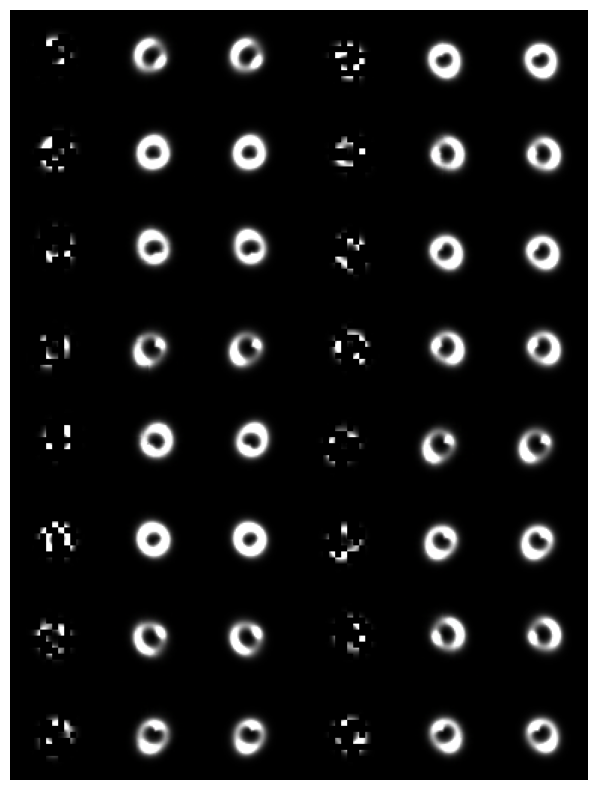

100%|██████████| 1657/1657 [01:39<00:00, 16.67it/s]


Epoch : 11 Loss : 0.0001811420515878126
Test Loss : 0.00022148571033785874


100%|██████████| 1657/1657 [01:41<00:00, 16.34it/s]


Epoch : 12 Loss : 0.00020425987895578146
Test Loss : 0.00014873487293575512


100%|██████████| 1657/1657 [01:42<00:00, 16.12it/s]


Epoch : 13 Loss : 0.00016307728947140276
Test Loss : 0.00019370674291732594


100%|██████████| 1657/1657 [01:43<00:00, 16.01it/s]


Epoch : 14 Loss : 9.351711923955008e-05
Test Loss : 0.00021369638829177396


100%|██████████| 1657/1657 [01:35<00:00, 17.33it/s]


Epoch : 15 Loss : 9.413176303496584e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007686302..1.0447388].


Test Loss : 0.00014771446735107314


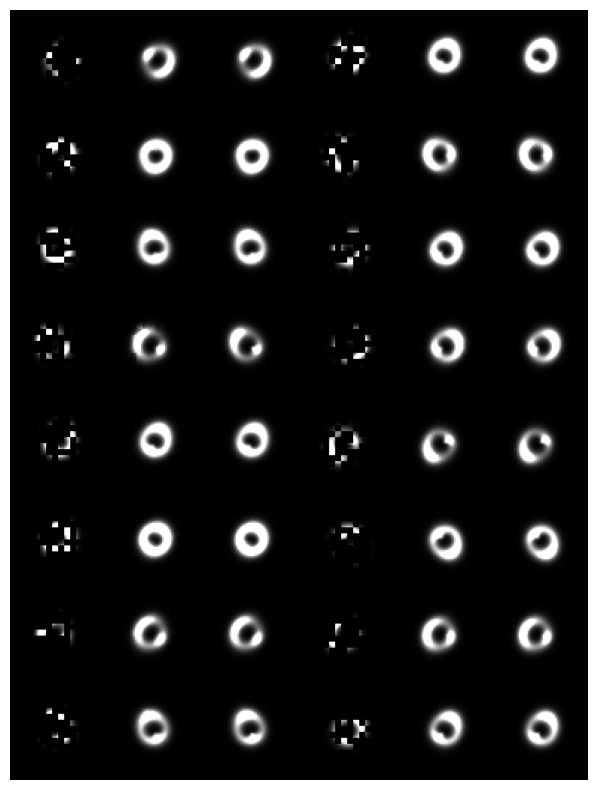

100%|██████████| 1657/1657 [01:43<00:00, 16.06it/s]


Epoch : 16 Loss : 0.00011944452853640541
Test Loss : 0.00014863073911574492


100%|██████████| 1657/1657 [01:39<00:00, 16.58it/s]


Epoch : 17 Loss : 0.00011399720096960664
Test Loss : 0.00016502095103213514


100%|██████████| 1657/1657 [01:40<00:00, 16.50it/s]


Epoch : 18 Loss : 9.303534170612693e-05
Test Loss : 0.00011433549071945301


100%|██████████| 1657/1657 [01:38<00:00, 16.75it/s]


Epoch : 19 Loss : 0.00012472650269046426
Test Loss : 0.0001317106288813709


100%|██████████| 1657/1657 [01:41<00:00, 16.32it/s]


Epoch : 20 Loss : 7.506845577154309e-05
Test Loss : 0.0001133364029728172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0061994977..1.0261073].


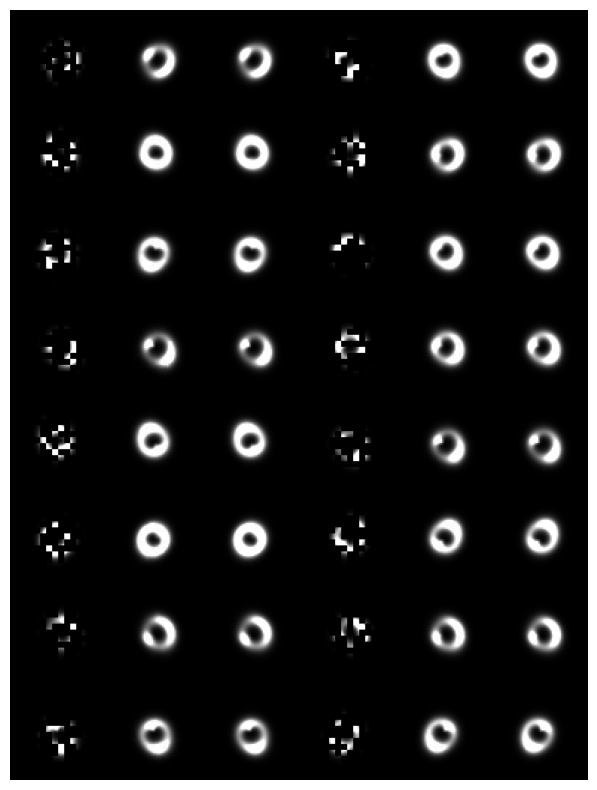

100%|██████████| 1657/1657 [01:36<00:00, 17.18it/s]


Epoch : 21 Loss : 4.3471762182889506e-05
Test Loss : 9.091217123912774e-05


100%|██████████| 1657/1657 [01:38<00:00, 16.90it/s]


Epoch : 22 Loss : 0.00011508956959005445
Test Loss : 0.00010307237109274767


100%|██████████| 1657/1657 [01:37<00:00, 16.91it/s]


Epoch : 23 Loss : 0.00011994408851023763
Test Loss : 0.00017334467796703196


100%|██████████| 1657/1657 [01:37<00:00, 16.93it/s]


Epoch : 24 Loss : 5.637621507048607e-05
Test Loss : 8.80653403402067e-05


100%|██████████| 1657/1657 [01:38<00:00, 16.88it/s]


Epoch : 25 Loss : 5.296767267282121e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00320708..1.0381684].


Test Loss : 8.792615850767549e-05


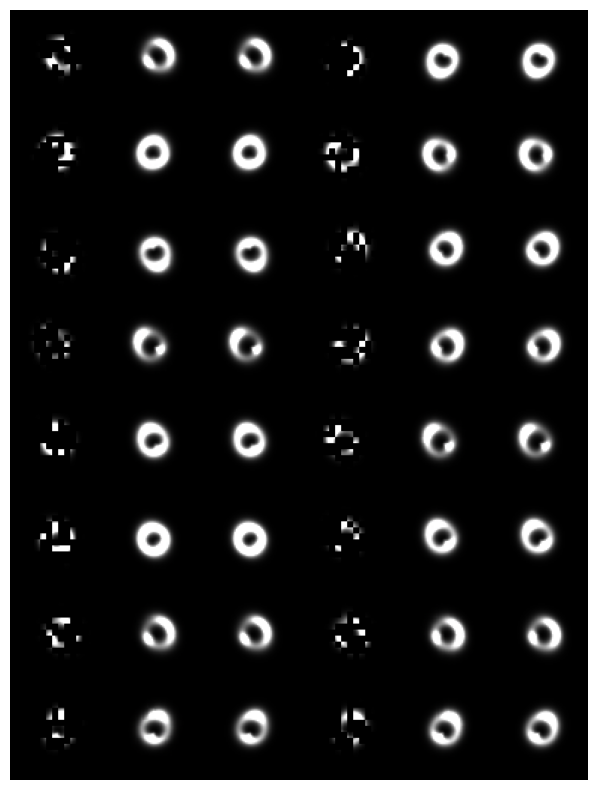

100%|██████████| 1657/1657 [01:38<00:00, 16.90it/s]


Epoch : 26 Loss : 9.037407289724797e-05
Test Loss : 6.429231131757685e-05


100%|██████████| 1657/1657 [01:33<00:00, 17.76it/s]


Epoch : 27 Loss : 8.753524161875248e-05
Test Loss : 8.297034262402637e-05


100%|██████████| 1657/1657 [01:38<00:00, 16.88it/s]


Epoch : 28 Loss : 5.1511589845176786e-05
Test Loss : 5.9291707785214876e-05


100%|██████████| 1657/1657 [01:38<00:00, 16.88it/s]


Epoch : 29 Loss : 4.656593227991834e-05
Test Loss : 6.555398987886194e-05


100%|██████████| 1657/1657 [01:38<00:00, 16.91it/s]


Epoch : 30 Loss : 3.1578587368130684e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.002835596..1.0287688].


Test Loss : 6.072374345495592e-05


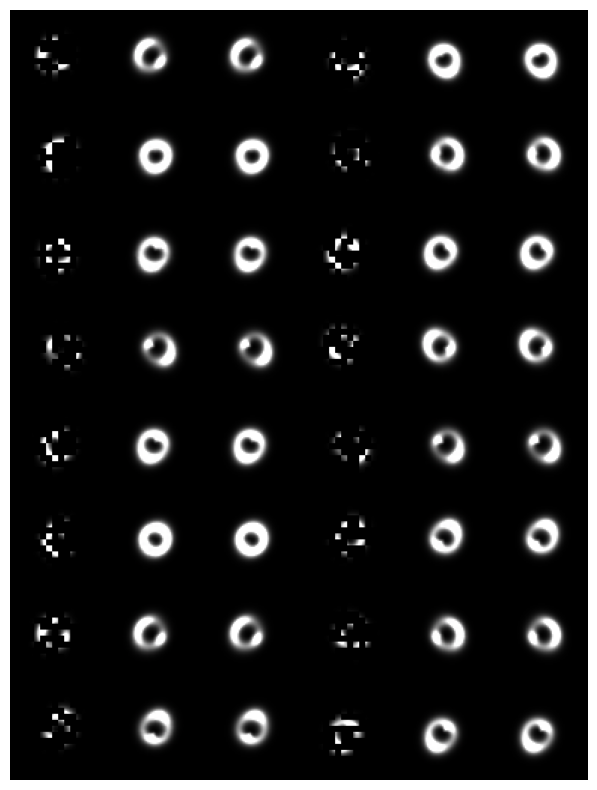

100%|██████████| 1657/1657 [01:37<00:00, 16.91it/s]


Epoch : 31 Loss : 4.728031490230933e-05
Test Loss : 7.106546926897372e-05


100%|██████████| 1657/1657 [01:38<00:00, 16.79it/s]


Epoch : 32 Loss : 0.00013491556455846876
Test Loss : 7.688458584173507e-05


100%|██████████| 1657/1657 [01:35<00:00, 17.34it/s]


Epoch : 33 Loss : 0.00012583057105075568
Test Loss : 7.337483479499792e-05


100%|██████████| 1657/1657 [01:40<00:00, 16.52it/s]


Epoch : 34 Loss : 4.398456076160073e-05
Test Loss : 6.462559183607998e-05


100%|██████████| 1657/1657 [01:39<00:00, 16.57it/s]


Epoch : 35 Loss : 7.034636655589566e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0018141938..1.0305692].


Test Loss : 4.1516946421816595e-05


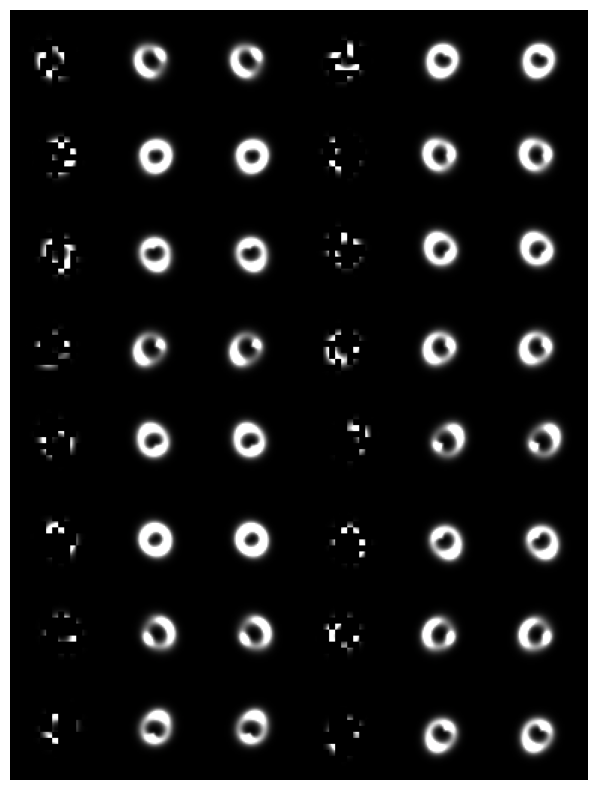

100%|██████████| 1657/1657 [01:39<00:00, 16.62it/s]


Epoch : 36 Loss : 2.4871504137990996e-05
Test Loss : 4.271042131664659e-05


100%|██████████| 1657/1657 [01:39<00:00, 16.66it/s]


Epoch : 37 Loss : 8.303520735353231e-05
Test Loss : 6.629291730515998e-05


100%|██████████| 1657/1657 [00:49<00:00, 33.73it/s]


Epoch : 38 Loss : 4.8905651055974886e-05
Test Loss : 5.5340127584861115e-05


100%|██████████| 1657/1657 [00:46<00:00, 35.47it/s]


Epoch : 39 Loss : 3.7944282667012885e-05
Test Loss : 4.6955028183465646e-05


100%|██████████| 1657/1657 [00:46<00:00, 35.42it/s]


Epoch : 40 Loss : 4.4335749407764524e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0019203499..1.0276788].


Test Loss : 5.2617780543310014e-05


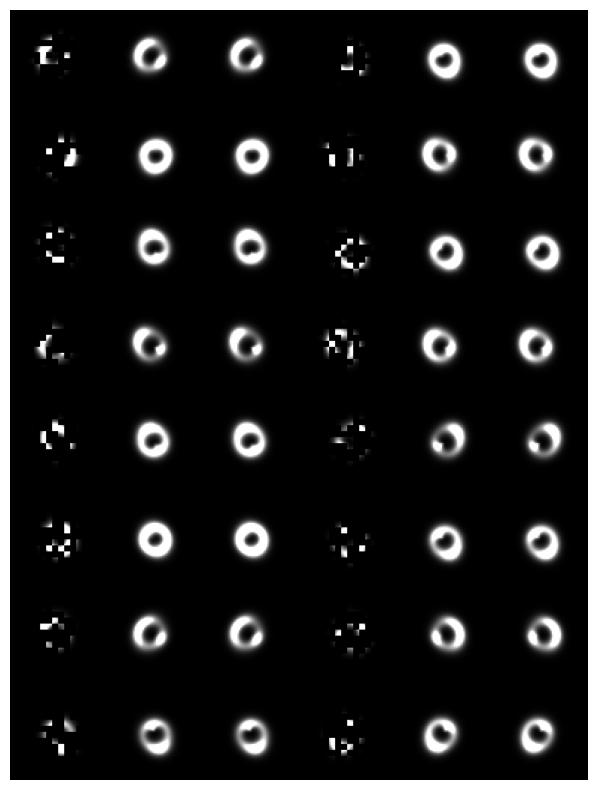

100%|██████████| 1657/1657 [00:46<00:00, 35.28it/s]


Epoch : 41 Loss : 2.6449348297319375e-05
Test Loss : 3.857691017155712e-05


100%|██████████| 1657/1657 [00:47<00:00, 34.60it/s]


Epoch : 42 Loss : 2.8254969947738573e-05
Test Loss : 3.5156177870482456e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.32it/s]


Epoch : 43 Loss : 4.197633461444639e-05
Test Loss : 3.464459446518418e-05


100%|██████████| 1657/1657 [00:49<00:00, 33.77it/s]


Epoch : 44 Loss : 5.042990960646421e-05
Test Loss : 7.946603718910656e-05


100%|██████████| 1657/1657 [00:48<00:00, 33.86it/s]


Epoch : 45 Loss : 1.727397830109112e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0019379668..1.0210358].


Test Loss : 5.9000148256608234e-05


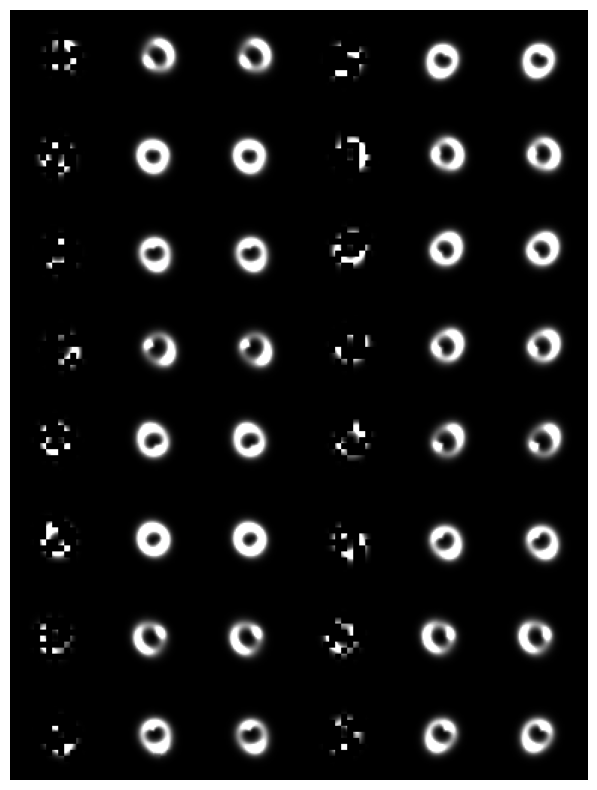

100%|██████████| 1657/1657 [00:48<00:00, 33.82it/s]


Epoch : 46 Loss : 2.4185221263905987e-05
Test Loss : 5.350745151510047e-05


100%|██████████| 1657/1657 [00:48<00:00, 33.99it/s]


Epoch : 47 Loss : 2.994741043949034e-05
Test Loss : 2.689414176455938e-05


100%|██████████| 1657/1657 [00:48<00:00, 33.86it/s]


Epoch : 48 Loss : 5.253818744677119e-05
Test Loss : 4.162653952064559e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.29it/s]


Epoch : 49 Loss : 2.8038053642376326e-05
Test Loss : 2.8456742084755035e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.45it/s]


Epoch : 50 Loss : 0.0005531018832698464


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0021263547..1.0126454].


Test Loss : 4.7307726325360255e-05


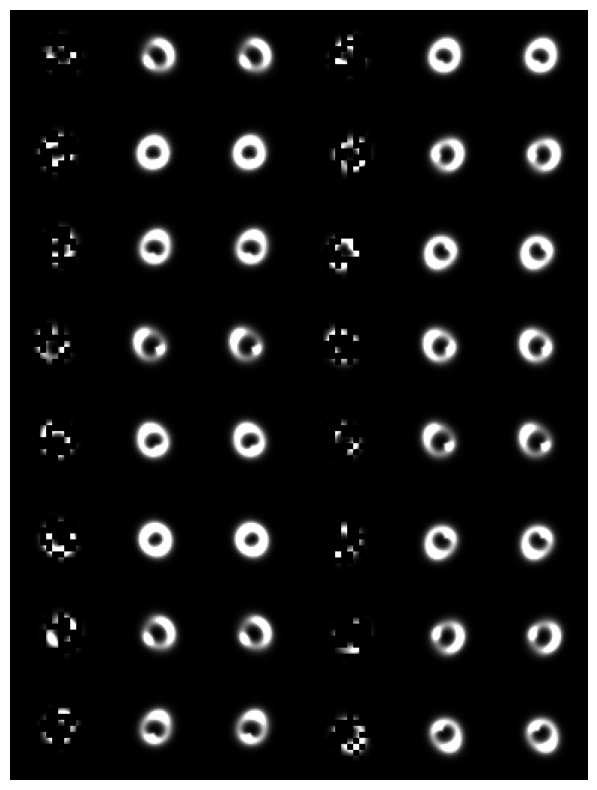

100%|██████████| 1657/1657 [00:47<00:00, 34.53it/s]


Epoch : 51 Loss : 1.5249874195433222e-05
Test Loss : 2.9490118745220448e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.49it/s]


Epoch : 52 Loss : 6.625372770940885e-05
Test Loss : 4.1898093980774786e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.32it/s]


Epoch : 53 Loss : 1.2571202205435839e-05
Test Loss : 2.0418114195923114e-05


100%|██████████| 1657/1657 [00:47<00:00, 35.16it/s]


Epoch : 54 Loss : 1.9670525944093242e-05
Test Loss : 2.1081220217417246e-05


100%|██████████| 1657/1657 [00:46<00:00, 35.29it/s]


Epoch : 55 Loss : 2.5561064830981195e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0018615965..1.0183896].


Test Loss : 2.8523328256670612e-05


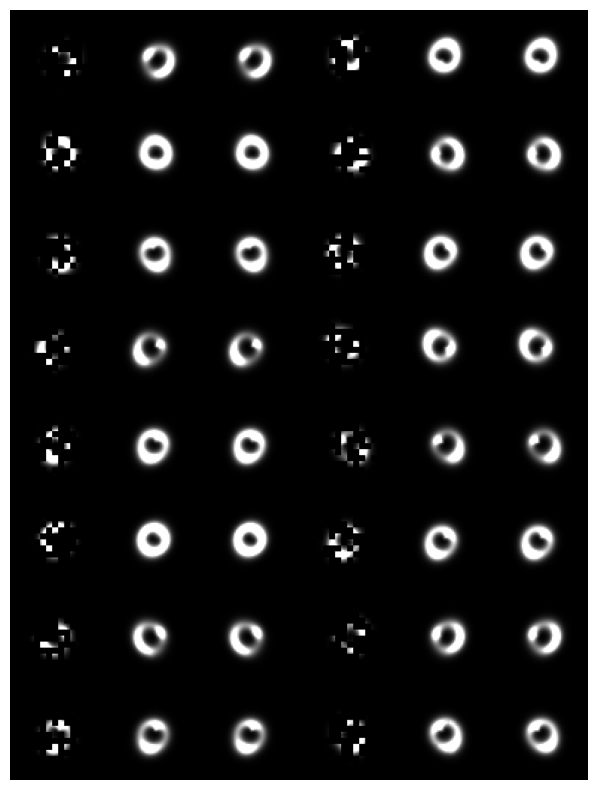

100%|██████████| 1657/1657 [00:47<00:00, 35.23it/s]


Epoch : 56 Loss : 1.2264506040082779e-05
Test Loss : 1.943768846202245e-05


100%|██████████| 1657/1657 [00:47<00:00, 35.06it/s]


Epoch : 57 Loss : 1.186666759167565e-05
Test Loss : 1.8714082840675916e-05


100%|██████████| 1657/1657 [00:47<00:00, 35.04it/s]


Epoch : 58 Loss : 1.7230368030141108e-05
Test Loss : 1.6297713645562417e-05


100%|██████████| 1657/1657 [00:47<00:00, 34.88it/s]


Epoch : 59 Loss : 1.1450475540186744e-05
Test Loss : 1.6187272442924014e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.14it/s]


Epoch : 60 Loss : 2.7656393285724334e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.002167223..1.0133275].


Test Loss : 5.48453343858332e-05


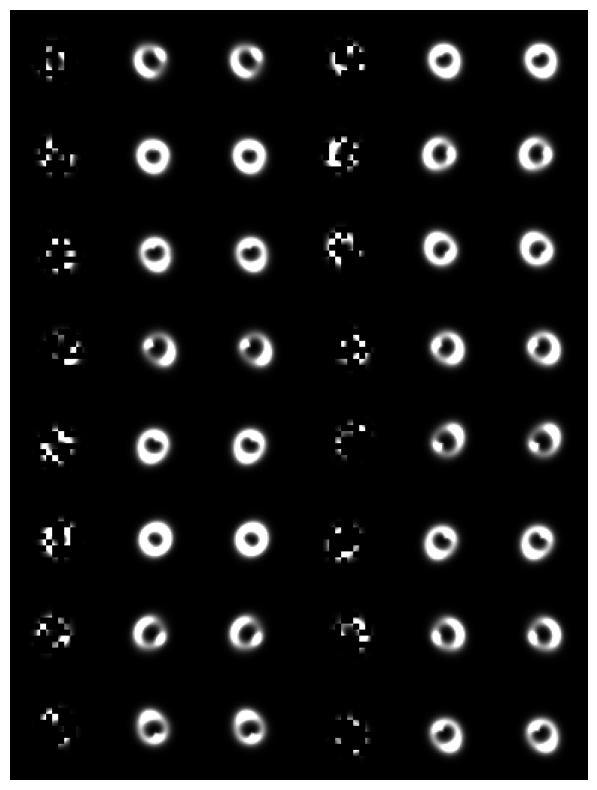

100%|██████████| 1657/1657 [00:47<00:00, 34.99it/s]


Epoch : 61 Loss : 1.1722278941306286e-05
Test Loss : 1.4315198029942473e-05


100%|██████████| 1657/1657 [00:47<00:00, 35.18it/s]


Epoch : 62 Loss : 1.847911516961176e-05
Test Loss : 1.7175050114117863e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.45it/s]


Epoch : 63 Loss : 9.440604117116891e-06
Test Loss : 1.366357834273446e-05


100%|██████████| 1657/1657 [00:47<00:00, 35.05it/s]


Epoch : 64 Loss : 9.575132025929634e-06
Test Loss : 1.757788931344466e-05


100%|██████████| 1657/1657 [00:47<00:00, 34.96it/s]


Epoch : 65 Loss : 1.2598531611729413e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0016511623..1.0180252].


Test Loss : 1.4627359576332162e-05


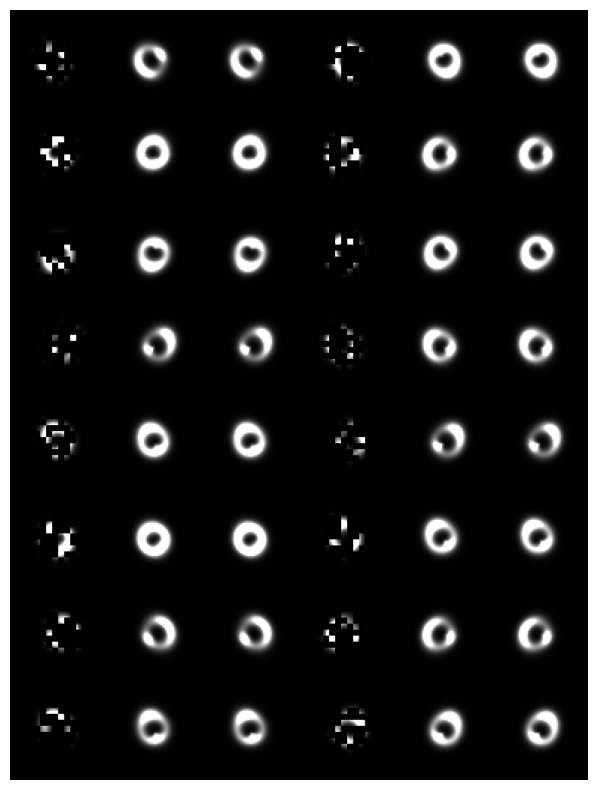

100%|██████████| 1657/1657 [00:47<00:00, 34.68it/s]


Epoch : 66 Loss : 9.354424946650397e-06
Test Loss : 1.2435319574767679e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.24it/s]


Epoch : 67 Loss : 6.229910923138959e-06
Test Loss : 1.3843963222678066e-05


100%|██████████| 1657/1657 [00:47<00:00, 35.16it/s]


Epoch : 68 Loss : 5.2088826123508625e-06
Test Loss : 1.1454371795824389e-05


100%|██████████| 1657/1657 [00:47<00:00, 35.20it/s]


Epoch : 69 Loss : 1.6818368749227375e-05
Test Loss : 1.2430779605819152e-05


100%|██████████| 1657/1657 [00:47<00:00, 34.81it/s]


Epoch : 70 Loss : 1.416771556250751e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0013121814..1.0128051].


Test Loss : 1.1502405966992327e-05


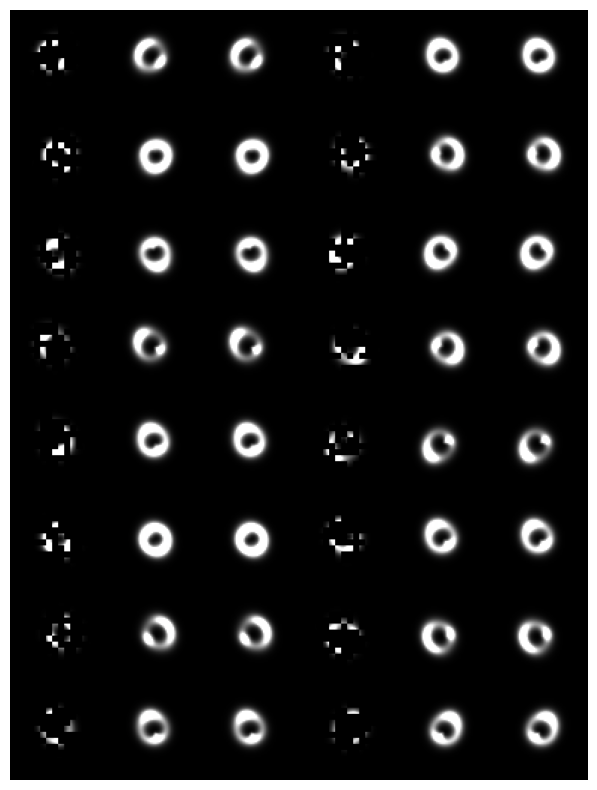

100%|██████████| 1657/1657 [00:47<00:00, 35.21it/s]


Epoch : 71 Loss : 4.752695076604141e-06
Test Loss : 1.3547140526891265e-05


100%|██████████| 1657/1657 [00:47<00:00, 34.81it/s]


Epoch : 72 Loss : 7.180441571108531e-06
Test Loss : 1.0849022178386017e-05


100%|██████████| 1657/1657 [00:47<00:00, 34.66it/s]


Epoch : 73 Loss : 7.283137165359221e-06
Test Loss : 9.19033240328694e-06


100%|██████████| 1657/1657 [00:47<00:00, 34.84it/s]


Epoch : 74 Loss : 1.0345445843995549e-05
Test Loss : 7.836712368746678e-06


100%|██████████| 1657/1657 [00:47<00:00, 34.90it/s]


Epoch : 75 Loss : 6.703477083647158e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012298413..1.0110475].


Test Loss : 8.008767793865912e-06


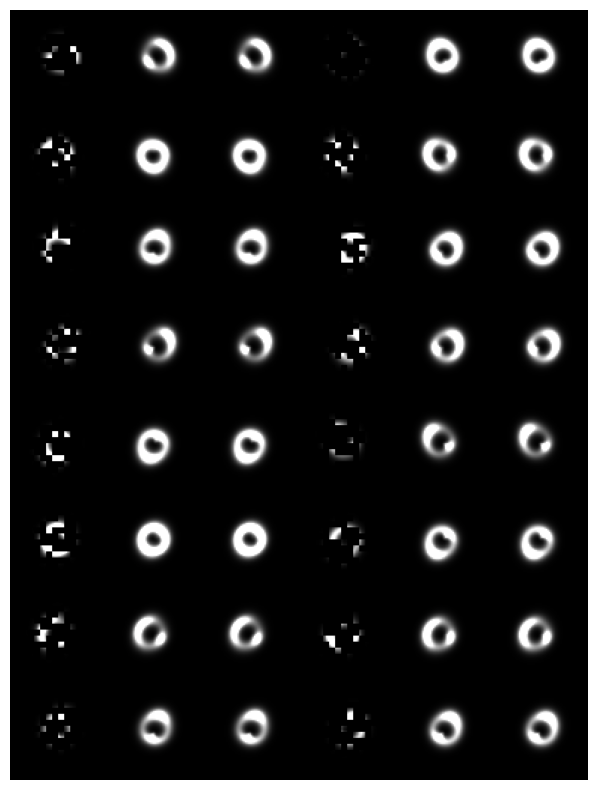

100%|██████████| 1657/1657 [00:47<00:00, 34.76it/s]


Epoch : 76 Loss : 1.6163992768269964e-05
Test Loss : 1.1454351499343977e-05


100%|██████████| 1657/1657 [00:48<00:00, 34.27it/s]


Epoch : 77 Loss : 1.0124581422132906e-05
Test Loss : 1.1912571963458086e-05


100%|██████████| 1657/1657 [00:47<00:00, 35.16it/s]


Epoch : 78 Loss : 9.002096703625284e-06
Test Loss : 6.674443362941462e-06


100%|██████████| 1657/1657 [00:47<00:00, 34.92it/s]


Epoch : 79 Loss : 5.196437086851802e-06
Test Loss : 7.272677590368108e-06


100%|██████████| 1657/1657 [00:47<00:00, 34.56it/s]


Epoch : 80 Loss : 9.778639650903642e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012815334..1.0117397].


Test Loss : 8.950141668842785e-06


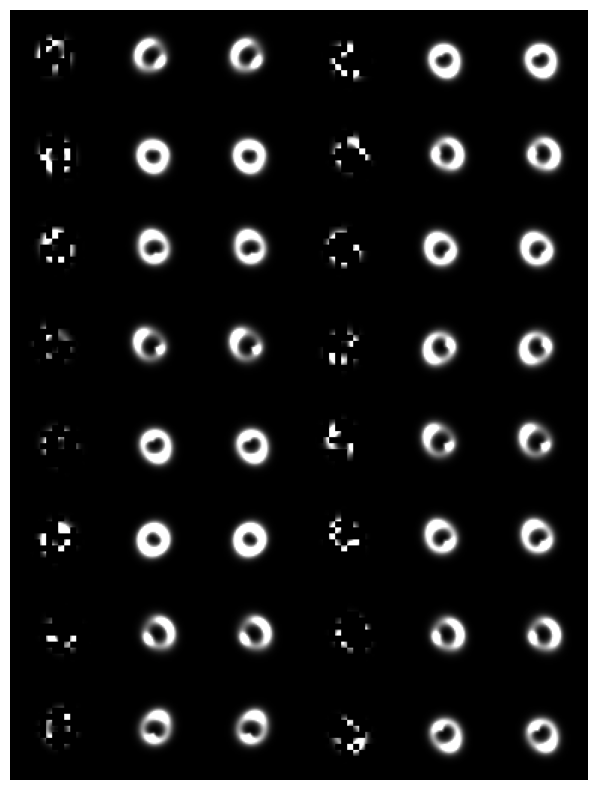

100%|██████████| 1657/1657 [00:47<00:00, 34.84it/s]


Epoch : 81 Loss : 4.900806288787862e-06
Test Loss : 7.696707182952416e-06


100%|██████████| 1657/1657 [00:49<00:00, 33.58it/s]


Epoch : 82 Loss : 5.218294063524809e-06
Test Loss : 5.877460209277972e-06


100%|██████████| 1657/1657 [00:48<00:00, 34.16it/s]


Epoch : 83 Loss : 4.399169938551495e-06
Test Loss : 6.628207942461862e-06


100%|██████████| 1657/1657 [00:49<00:00, 33.31it/s]


Epoch : 84 Loss : 6.98381700203754e-06
Test Loss : 5.909813107545897e-06


100%|██████████| 1657/1657 [00:49<00:00, 33.63it/s]


Epoch : 85 Loss : 6.841387403255794e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0010747425..1.0128073].


Test Loss : 5.42805100849364e-06


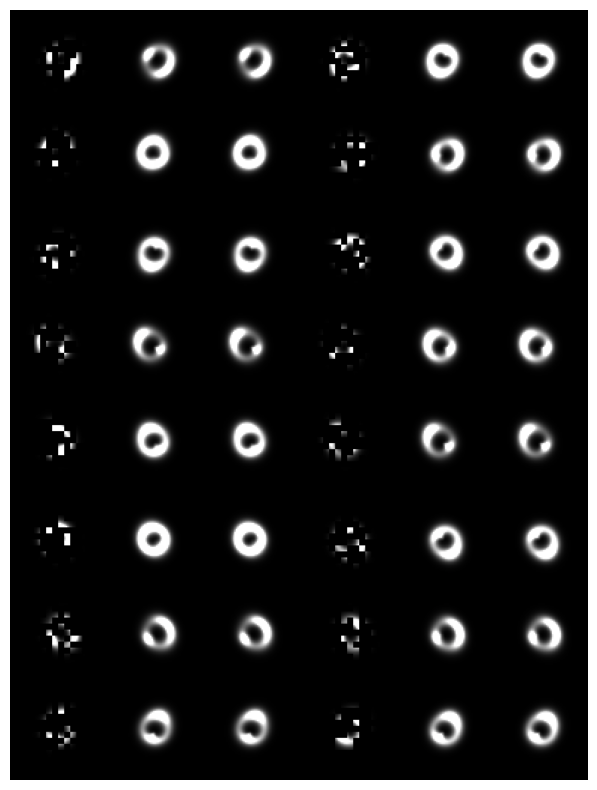

100%|██████████| 1657/1657 [00:48<00:00, 34.21it/s]


Epoch : 86 Loss : 4.717604497272987e-06
Test Loss : 6.304075737421659e-06


100%|██████████| 1657/1657 [00:47<00:00, 34.72it/s]


Epoch : 87 Loss : 4.301619810576085e-06
Test Loss : 5.508737772411346e-06


100%|██████████| 1657/1657 [00:48<00:00, 34.41it/s]


Epoch : 88 Loss : 3.998227839474566e-06
Test Loss : 6.471264322425594e-06


100%|██████████| 1657/1657 [00:50<00:00, 32.71it/s]


Epoch : 89 Loss : 2.3530922135250876e-06
Test Loss : 5.114666725136419e-06


100%|██████████| 1657/1657 [00:48<00:00, 34.37it/s]


Epoch : 90 Loss : 3.5894813663617242e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0012450479..1.0108701].


Test Loss : 5.487309643384022e-06


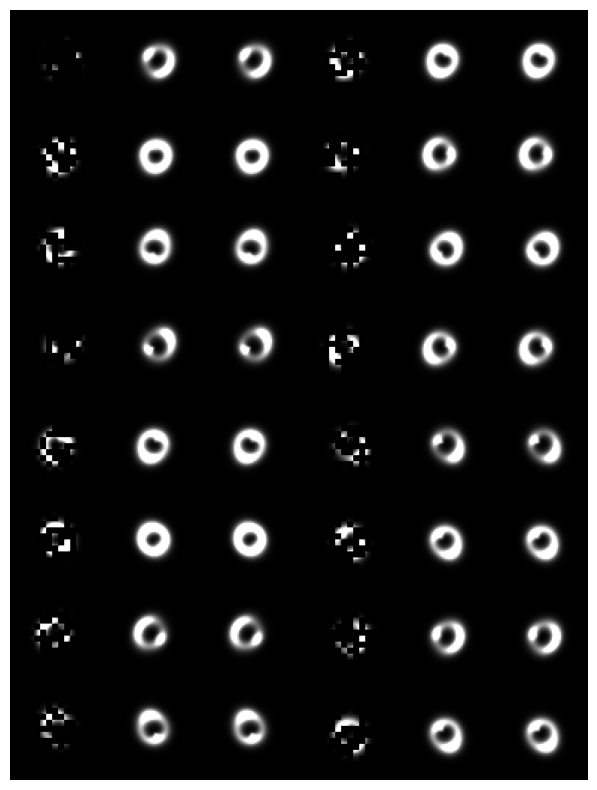

100%|██████████| 1657/1657 [00:48<00:00, 34.34it/s]


Epoch : 91 Loss : 7.447211828548461e-06
Test Loss : 5.3409753245186705e-06


100%|██████████| 1657/1657 [00:49<00:00, 33.68it/s]


Epoch : 92 Loss : 4.076372533745598e-06
Test Loss : 4.865521436472222e-06


100%|██████████| 1657/1657 [00:48<00:00, 34.43it/s]


Epoch : 93 Loss : 3.8973612390691414e-06
Test Loss : 4.708377185591883e-06


100%|██████████| 1657/1657 [00:48<00:00, 34.27it/s]


Epoch : 94 Loss : 6.746403414581437e-06
Test Loss : 4.846270683235678e-06


100%|██████████| 1657/1657 [00:49<00:00, 33.72it/s]


Epoch : 95 Loss : 2.1039866169303423e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0011565201..1.012469].


Test Loss : 4.942574410174652e-06


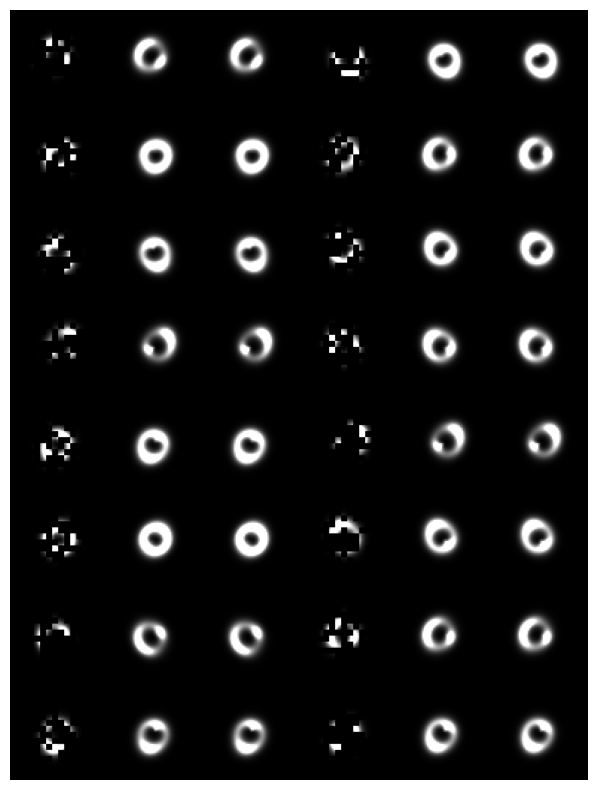

100%|██████████| 1657/1657 [00:49<00:00, 33.24it/s]


Epoch : 96 Loss : 4.564553819363937e-06
Test Loss : 5.051638559175567e-06


100%|██████████| 1657/1657 [00:49<00:00, 33.55it/s]


Epoch : 97 Loss : 4.336573510954622e-06
Test Loss : 4.809399473054548e-06


100%|██████████| 1657/1657 [00:49<00:00, 33.60it/s]


Epoch : 98 Loss : 6.537085027957801e-06
Test Loss : 5.1263156279133366e-06


100%|██████████| 1657/1657 [00:50<00:00, 33.04it/s]


Epoch : 99 Loss : 2.6743737180368043e-06
Test Loss : 4.845881651793182e-06


In [ ]:
#PreTraining

from torch.utils.data import DataLoader
from torch.optim import AdamW

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_size = 0.1

train_size = int(len(dataset_train) * (1 - test_size))
test_size = len(dataset_train) - train_size

dataset_train, dataset_test = torch.utils.data.random_split(dataset_train, [train_size, test_size] , generator=torch.Generator().manual_seed(42))


train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False)

model = MAE_ViT( image_size=64, patch_size=4, emb_dim=192, encoder_layer=12, encoder_head=3, decoder_layer=4, decoder_head=3, mask_ratio=0.75).to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)

model.train()

EPOCHS = 100

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

save_path = "pretrain_model"

os.makedirs(save_path, exist_ok=True)
best_loss = 1e9

for epoch in range(EPOCHS):
    model.train()
    for img, _ in tqdm(train_loader):
        img = img.to(device)
        optimizer.zero_grad()
        predicted_img, mask = model(img)

        loss = torch.mean((predicted_img - img) ** 2 * mask / 0.75)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch : {epoch} Loss : {loss.item()}")
    # if loss.item() < best_loss:
    #     best_loss = loss.item()
    #     torch.save(model.state_dict(), save_path + "/model_vit_t.pth")

    #Plot 5 images after each epoch

    

    model.eval()


    test_loss = 0
    for img, _ in test_loader:
        img = img.to(device)
        predicted_img, mask = model(img)
        test_loss += torch.mean((predicted_img - img) ** 2 * mask / 0.75).item()

    print(f"Test Loss : {test_loss / len(test_loader)}")

    if test_loss / len(test_loader) < best_loss:
        best_loss = test_loss / len(test_loader)
        torch.save(model.state_dict(), save_path + "/model_vit_t.pth")

    if epoch % 5 != 0:
        continue
    with torch.no_grad():
        val_img = torch.stack([dataset_test[i][0] for i in range(16)])
        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)
        predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
        img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
        img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
        img = img.permute(1, 2, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(img.cpu())
    plt.axis("off")


    # plt.savefig(f"pretrain_image_{epoch}.png")
    plt.show()
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0014947094..1.0117166].


Test Loss : 5.296447373566931e-06


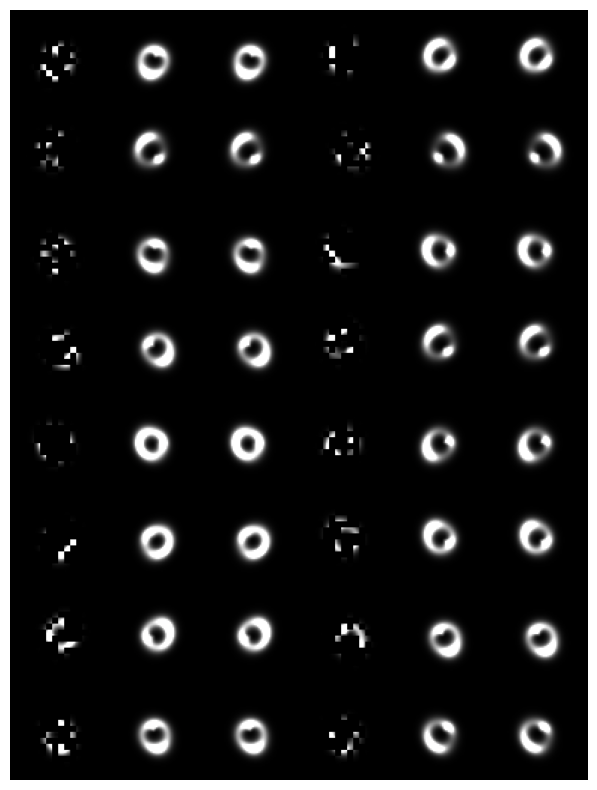

In [22]:
#Load best model
from torch.utils.data import DataLoader
test_size = 0.1

train_size = int(len(dataset_train) * (1 - test_size))
test_size = len(dataset_train) - train_size

dataset_train, dataset_test = torch.utils.data.random_split(dataset_train, [train_size, test_size] , generator=torch.Generator().manual_seed(42))


train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MAE_ViT( image_size=64, patch_size=4, emb_dim=192, encoder_layer=12, encoder_head=3, decoder_layer=4, decoder_head=3, mask_ratio=0.75).to(device)
model.load_state_dict(torch.load("pretrain_model" + "/model_vit_t.pth"))

model.eval()



loss = 0

for img, _ in test_loader:
    img = img.to(device)
    predicted_img, mask = model(img)
    loss += torch.mean((predicted_img - img) ** 2 * mask / 0.75).item()

print(f"Test Loss : {loss / len(test_loader)}")

# torch.save(model , "pretrain_model/model_vit_t_model_best.pth")

torch.save(model.state_dict(), "pretrain_model/model_vit_t_best.pth")

#Plot

with torch.no_grad():
    val_img = torch.stack([dataset_test[i][0] for i in range(16)])
    val_img = val_img.to(device)
    predicted_val_img, mask = model(val_img)
    predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
    img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
    img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
    img = img.permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(img.cpu())
plt.axis("off")

plt.show()
